# Growth Trajectories by Stage and Segment

This notebook compares Moody's projected percent changes in employment, wages, and GDP/GPO between Michigan and the United States for 2024-2030. Data sources:

- `data/interim/moodys_michigan_2024_2030.csv`
- `data/interim/moodys_us_2024_2030.csv`
- Aggregations generated by `scripts/aggregate_moodys_segments.py`


In [25]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='talk', style='whitegrid')
project_root = Path.cwd()
if not (project_root / 'data').exists():
    project_root = project_root.parent
DATA_DIR = project_root / 'data' / 'interim'
FIG_DIR = project_root / 'reports' / 'figures'
CONFIG_DIR = project_root / 'config'
FIG_DIR.mkdir(parents=True, exist_ok=True)

metrics = ['employment', 'wages', 'gdp']
metric_labels = {'employment': 'Employment', 'wages': 'Wages', 'gdp': 'GDP/GPO'}
base_year, target_year = 2024, 2030

with open(CONFIG_DIR / 'colors.json') as f:
    colors = json.load(f)

geo_palette = {'Michigan': colors['teal'], 'United States': colors['red']}


In [26]:
stage_mi = pd.read_csv(DATA_DIR / 'moodys_michigan_stages_2024_2030.csv')
stage_us = pd.read_csv(DATA_DIR / 'moodys_us_stages_2024_2030.csv')
seg_mi = pd.read_csv(DATA_DIR / 'moodys_michigan_segments_2024_2030.csv')
seg_us = pd.read_csv(DATA_DIR / 'moodys_us_segments_2024_2030.csv')

stage_mi.head()


,stage,2024_employment,2030_employment,2024_wages,2030_wages,2024_gdp,2030_gdp,pct_change_employment_2024_2030,pct_change_wages_2024_2030,pct_change_gdp_2024_2030
0,Upstream,206.921313,194.931801,16108.374675,17668.725495,28932.253026,34898.066496,-5.794237,9.686581,20.619941
1,OEM,294.429628,300.649292,28622.799570,33899.878653,64539.827608,83939.219297,2.112445,18.436628,30.058016
2,Downstream,231.242885,229.739224,16021.201930,19259.330193,46872.074913,56718.692974,-0.650252,20.211519,21.007429


In [27]:
def reshape_stage(df: pd.DataFrame, geography: str) -> pd.DataFrame:
    tidy = df.copy()
    tidy['geography'] = geography
    value_cols = [f'pct_change_{metric}_{base_year}_{target_year}' for metric in metrics]
    tidy = tidy[['stage', 'geography'] + value_cols]
    tidy = tidy.melt(id_vars=['stage', 'geography'], value_vars=value_cols, var_name='metric', value_name='pct_change')
    tidy['metric'] = tidy['metric'].str.replace('pct_change_', '').str.replace(f'_{base_year}_{target_year}', '', regex=False)
    tidy['metric'] = tidy['metric'].map(metric_labels)
    tidy['stage'] = pd.Categorical(tidy['stage'], categories=['Upstream', 'OEM', 'Downstream'], ordered=True)
    return tidy

stage_long = pd.concat([
    reshape_stage(stage_mi, 'Michigan'),
    reshape_stage(stage_us, 'United States')
], ignore_index=True)

stage_long.head()


,stage,geography,metric,pct_change
0,Upstream,Michigan,Employment,-5.794237
1,OEM,Michigan,Employment,2.112445
2,Downstream,Michigan,Employment,-0.650252
3,Upstream,Michigan,Wages,9.686581
4,OEM,Michigan,Wages,18.436628


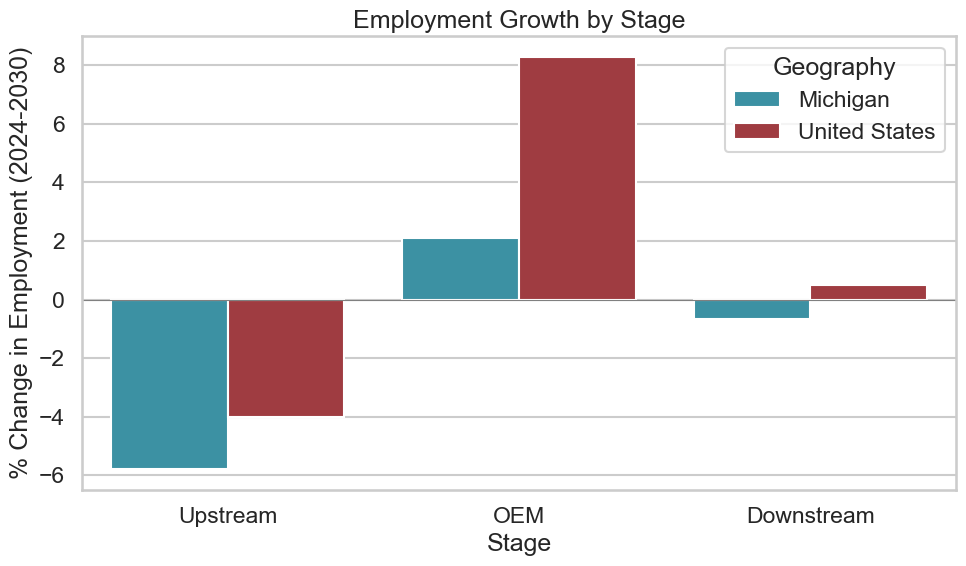

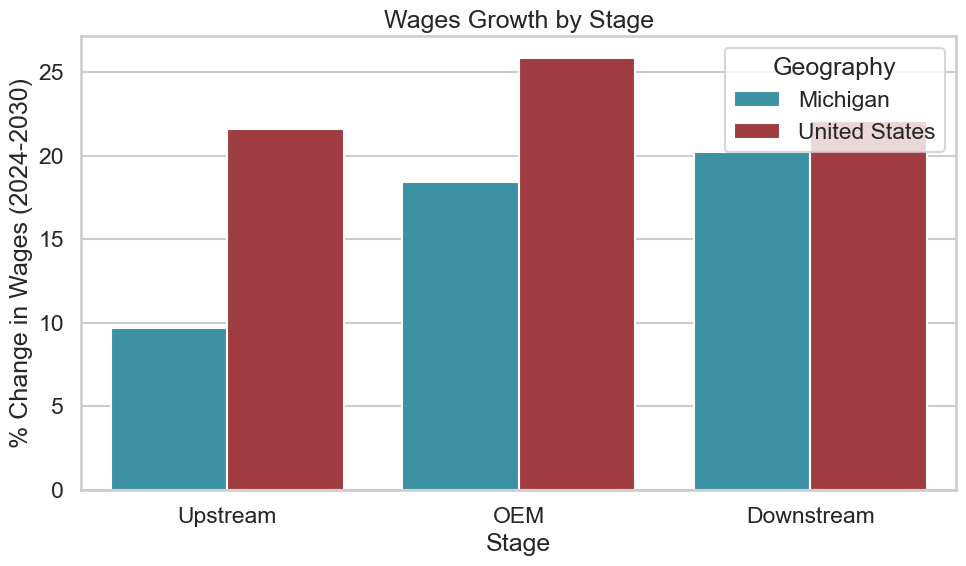

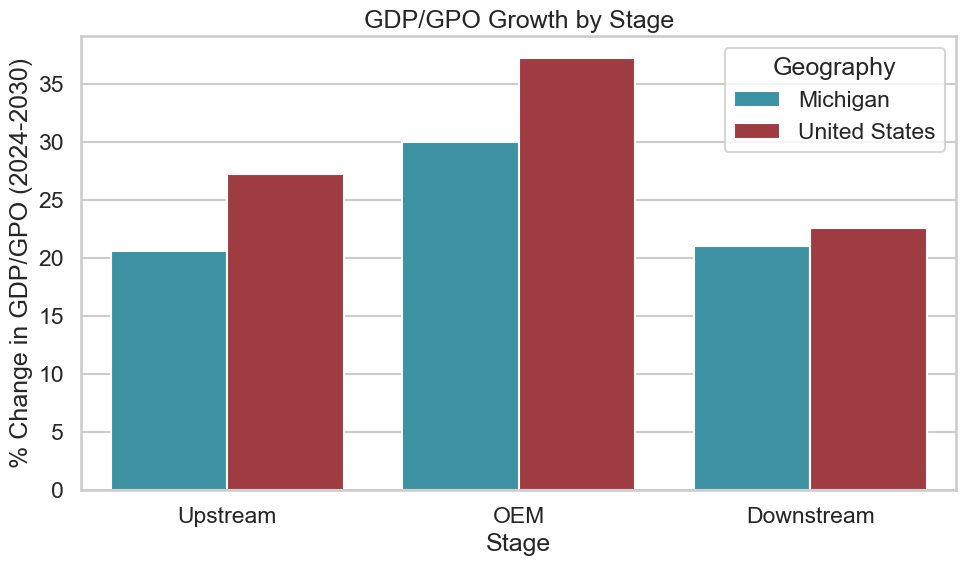

In [28]:
for metric_label in metric_labels.values():
    data = stage_long[stage_long['metric'] == metric_label]
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=data, x='stage', y='pct_change', hue='geography', hue_order=['Michigan', 'United States'], palette=geo_palette, ax=ax)
    ax.set_ylabel(f'% Change in {metric_label} ({base_year}-{target_year})')
    ax.set_xlabel('Stage')
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_title(f'{metric_label} Growth by Stage')
    ax.legend(title='Geography')
    fig.tight_layout()
    safe_label = metric_label.lower().replace('/', '').replace(' ', '_')
    output_path = FIG_DIR / f'stage_{safe_label}_pct_change_{base_year}_{target_year}.png'
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


In [29]:
def reshape_segment(df: pd.DataFrame, geography: str) -> pd.DataFrame:
    tidy = df.copy()
    tidy['segment_label'] = tidy['segment_id'].astype(int).astype(str) + '. ' + tidy['segment_name']
    tidy['geography'] = geography
    value_cols = [f'pct_change_{metric}_{base_year}_{target_year}' for metric in metrics]
    tidy = tidy[['segment_id', 'segment_label', 'geography'] + value_cols]
    tidy = tidy.melt(id_vars=['segment_id', 'segment_label', 'geography'], value_vars=value_cols, var_name='metric', value_name='pct_change')
    tidy['metric'] = tidy['metric'].str.replace('pct_change_', '').str.replace(f'_{base_year}_{target_year}', '', regex=False)
    tidy['metric'] = tidy['metric'].map(metric_labels)
    tidy = tidy.sort_values(['segment_id', 'metric'])
    return tidy

segment_long = pd.concat([
    reshape_segment(seg_mi, 'Michigan'),
    reshape_segment(seg_us, 'United States')
], ignore_index=True)

segment_long.head()


,segment_id,segment_label,geography,metric,pct_change
0,1,1. Materials & Processing,Michigan,Employment,-6.665361
1,1,1. Materials & Processing,Michigan,GDP/GPO,20.994651
2,1,1. Materials & Processing,Michigan,Wages,11.561728
3,2,2. Equipment Manufacturing,Michigan,Employment,-4.524320
4,2,2. Equipment Manufacturing,Michigan,GDP/GPO,8.980575


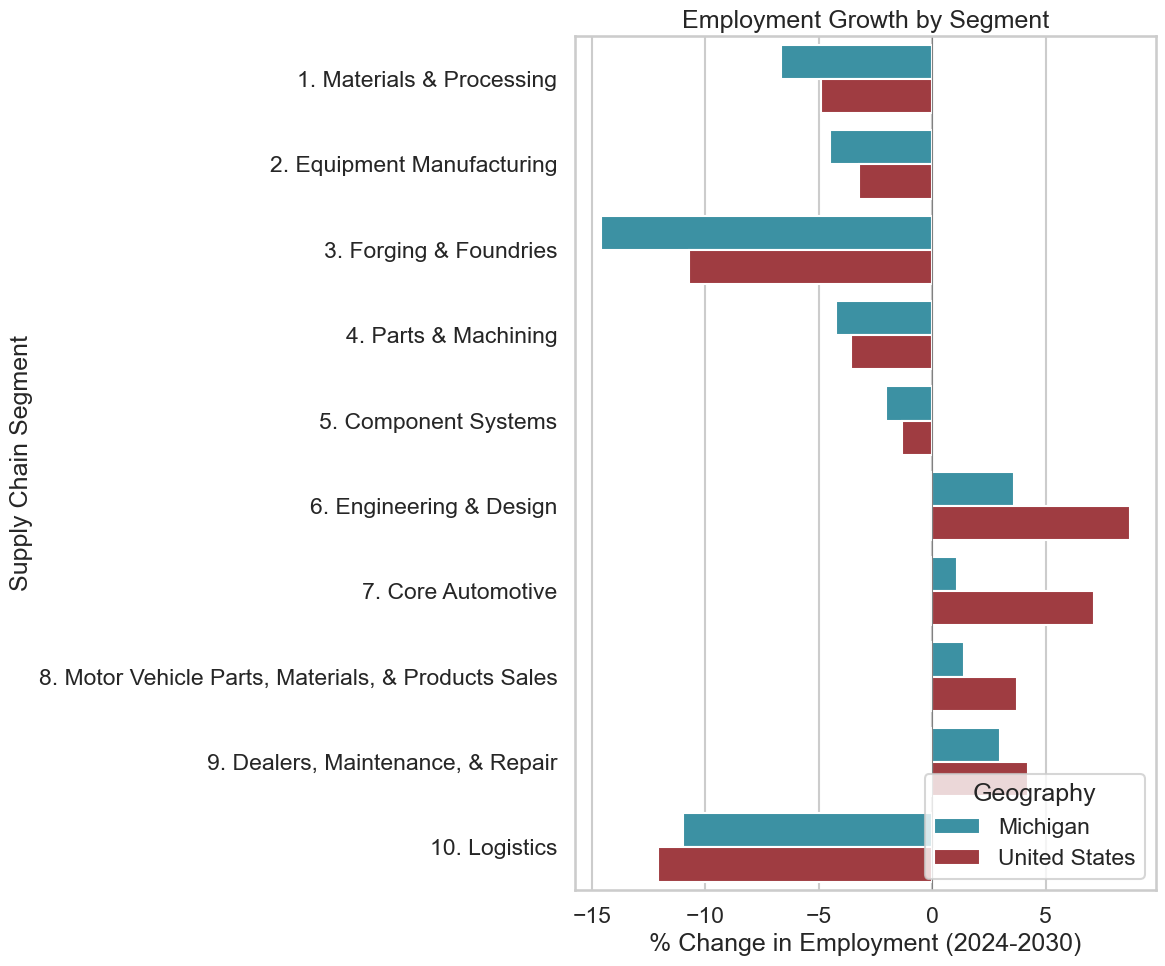

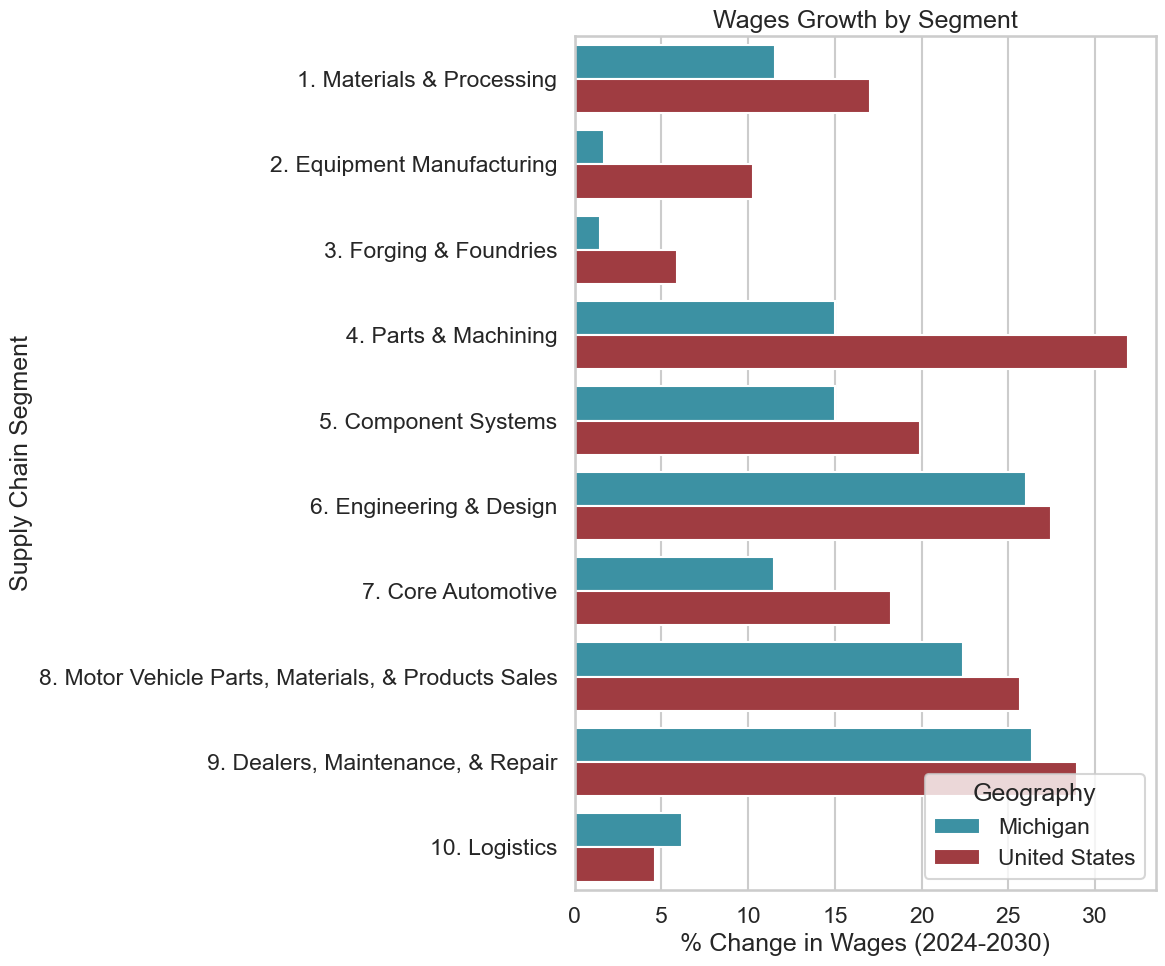

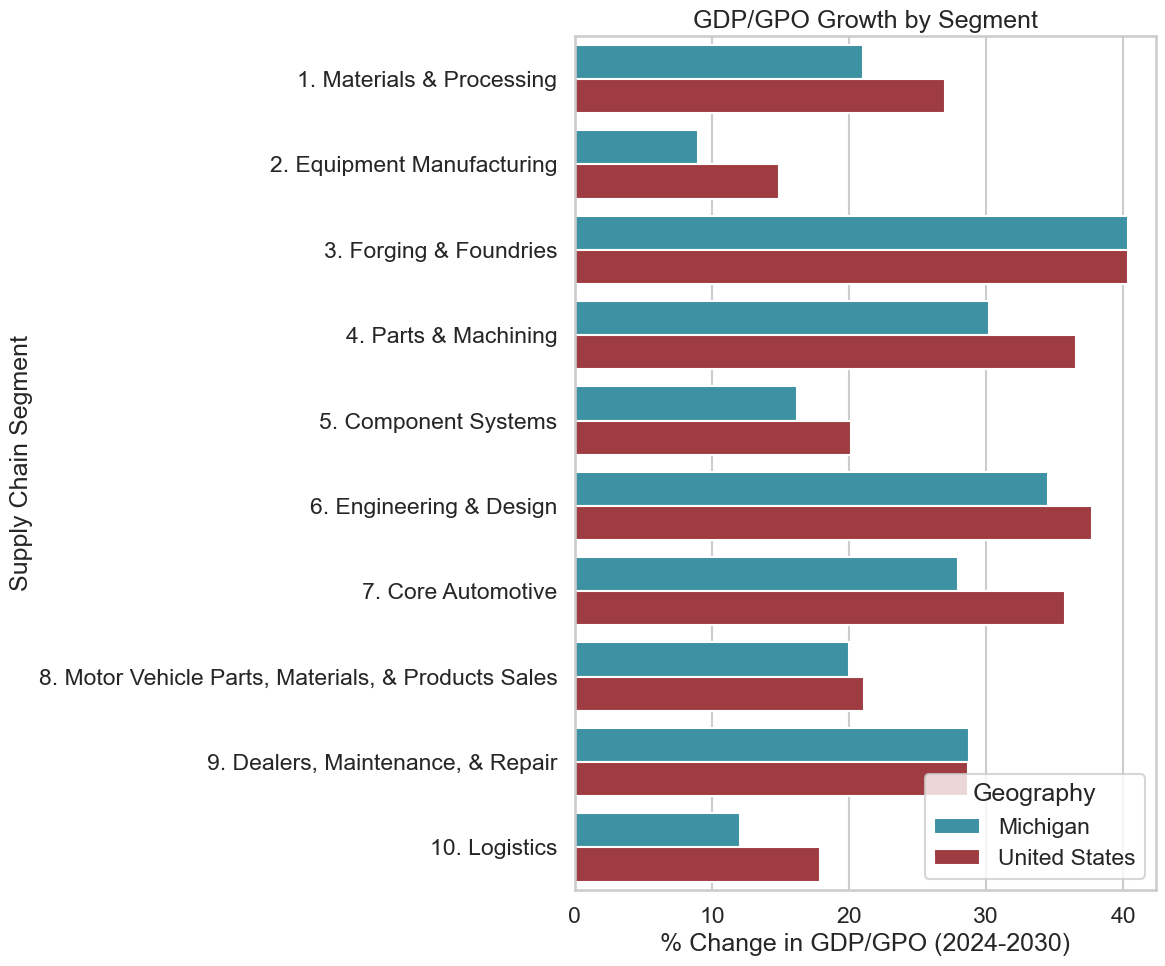

In [30]:
for metric_label in metric_labels.values():
    data = segment_long[segment_long['metric'] == metric_label]
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.barplot(data=data, y='segment_label', x='pct_change', hue='geography', hue_order=['Michigan', 'United States'], palette=geo_palette, ax=ax, orient='h')
    ax.set_xlabel(f'% Change in {metric_label} ({base_year}-{target_year})')
    ax.set_ylabel('Supply Chain Segment')
    ax.axvline(0, color='grey', linewidth=0.8)
    ax.set_title(f'{metric_label} Growth by Segment')
    ax.legend(title='Geography', loc='lower right')
    fig.tight_layout()
    safe_label = metric_label.lower().replace('/', '').replace(' ', '_')
    output_path = FIG_DIR / f'segment_{safe_label}_pct_change_{base_year}_{target_year}.png'
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


## Notes

- Percent change calculations use Moody's projections between 2024 and 2030 generated earlier in the workflow.
- Figures are exported to `reports/figures/` for inclusion in presentations or dashboards.
- Update the interim CSV files and re-run this notebook to refresh the visuals.
- Colors are sourced from `config/colors.json` so analytics and reporting assets share the same palette.
